In [1]:
import torch 
from torch import nn
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [998]:
def exp(x):
    return 0.1 * torch.exp(x)

class Symbolics:
    def __init__(self, symbols = []):#[torch.sin]):
        #symbols = [torch.sin, torch.cos, torch.log]
        self.symbols = symbols
        self.num_constants = 1
        self.coefs = nn.Linear(1,self.num_constants, bias = False, dtype = torch.complex64)
    def constants(self,x):
        ## x.shape = [Batch_size, 1]
        # learns constants for 
        return self.fc1(x)

    def __call__(self,x):
        return torch.hstack([x] + [func(x) for func in self.symbols])
        return torch.hstack([self.constants(torch.ones((x.shape[0],1)).to(torch.complex64)), x] + [func(x) for func in self.symbols])
    def m(self, n):
        return (len(self.symbols) + 1)*n #len(self.symbols) * n + 2 + self.num_constants ##2 is dim of x 

In [999]:
m = Symbolics()
m(torch.ones(5,5))

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [1025]:
class Featuremap_log:
    def __init__(self, eps):
        self.eps = eps
    def __call__(self,x):
        return torch.hstack((-1 * x, torch.log(x)))
    def m(self,n):
        return n * 2

class Featuremap_exp:
    def __init__(self):
        pass
    def nan_to_num_complex(self, tensor, nan=0.0, posinf=None, neginf=None):
        real_part = torch.nan_to_num(tensor.real, nan=nan, posinf=posinf, neginf=neginf)
        imag_part = torch.nan_to_num(tensor.imag, nan=nan, posinf=posinf, neginf=neginf)
        return torch.complex(real_part, imag_part)
        
    def __call__(self,x):
        return torch.exp(self.nan_to_num_complex(x, nan=-float('inf')))
    def m(self,n):
        return n

In [1001]:
import torch.nn.utils.prune as prune
import numpy as np

class ComplexMagnitudePruning(prune.BasePruningMethod):

    PRUNING_TYPE = 'unstructured'

    def __init__(self, threshold = 1e-2):
        super(ComplexMagnitudePruning, self).__init__()
        self.threshold = threshold  # Magnitude threshold for pruning

    def compute_mask(self, t, default_mask):
        """
        Prune weights based on the magnitude of the complex numbers.
        We prune elements where |w| < threshold.
        
        Arguments:
        - t: the parameter (weights) to prune (could be complex or real)
        - default_mask: the existing mask of the parameters
        
        Returns:
        - mask: the updated mask where 0 means pruned and 1 means kept
        """
        # Compute the magnitude of the complex weights

        # Create mask where weights with magnitude < threshold are pruned (set to 0)
        magnitude = torch.abs(t)
        mask = torch.where(magnitude >= self.threshold, 1,0)
        return mask


# Function to apply pruning to a model
def prune_weights(module, threshold, name='weight'):
    """
    Applies complex magnitude pruning to a specific parameter (like 'weight') of a module.
    
    Arguments:
    - module: the neural network layer (e.g., nn.Linear, nn.Conv2d) to prune
    - name: the name of the parameter to prune (usually 'weight')
    - threshold: the magnitude threshold below which weights are pruned
    """
    #pruning_method = ComplexMagnitudePruning(threshold=threshold)
    #pruning_method.apply(module, name=name)
    ComplexMagnitudePruning.apply(module, name)
    return module

In [1026]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        n = 2
        m = 1
        N = 3
        #self.coefs = nn.Linear(n + 1,self.num_constants, bias = False, dtype = torch.complex64)
        self.map = Symbolics()
        self.map_1 = Featuremap_log(eps = 0.1)
        self.map_2 = Featuremap_exp()
        #self.fc1 = nn.Linear(self.map_1.m(self.map.m(n)), N, bias = False, dtype = torch.complex64)
        self.fc1 = nn.Linear(self.map_1.m(self.map.m(n)), N, bias = False, dtype = torch.complex64)
        self.fc2 = nn.Linear(self.map_2.m(N), m, bias = False, dtype = torch.complex64)

    def forward(self, x):
        t_1 = self.map_1(self.map(x))
        #t_1 = self.map_1(self.map(x))
        f_1 = self.fc1(t_1)
        t_2 = self.map_2(f_1)
        f_2 = self.fc2(t_2)
        return f_2
        
    def plot_model(self):
        x = np.linspace(0, 1, 50)  # Example range for x
        y = np.linspace(0, 1, 50)  # Example range for y

        # Generate meshgrid
        X, Y = np.meshgrid(x, y)

        # Flatten the two meshgrid arrays
        X_flat = X.flatten()
        Y_flat = Y.flatten()

        mesh_data = np.stack((X_flat, Y_flat), axis=1)
        output = self(torch.tensor(mesh_data, dtype = torch.complex64))
        Z = output.real.reshape(50, 50)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis', edgecolor='none')
        ax.set_title('3D Surface Plot of f(x, y)')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('f(X, Y)')

        # Show the plot
        plt.show()




In [1004]:
model = Net()
model(torch.randn(10,2) + 0j)


tensor([[ 1.0373+2.0069j],
        [ 1.0434+1.1212j],
        [ 0.0734+0.0878j],
        [ 1.0027+0.9299j],
        [ 2.0630+2.0385j],
        [-0.0813+0.1310j],
        [ 0.5126+0.1086j],
        [ 0.3440+0.4156j],
        [ 0.6159+0.3582j],
        [ 1.0782+0.1365j]], grad_fn=<MmBackward0>)

In [1005]:
def apply_pruning(model, threshold):
    for name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                prune_weights(module, name='weight', threshold=threshold)
                #prune.l1_unstructured(module, name='bias', amount=0.4)
                #prune.remove(module, 'weight')
                #prune.remove(module, 'bias')

In [1006]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [1007]:
count_parameters(model)

15

In [1094]:
def validate(model, dataloader):
    loss_fn = torch.nn.MSELoss()
    model.eval()
    valid_loss = 0
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        out = model(x_batch)
        loss = loss_fn(out.real, y_batch.real) + loss_fn(out.imag, y_batch.imag)
        valid_loss += loss.item()
    return valid_loss

In [1104]:
def train(model, dataloader_train, dataloader_valid, epochs):
    loss_fn = torch.nn.MSELoss()
    optimizer = optim.RAdam(model.parameters(), lr=0.001)#, weight_decay=10e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', patience = 1, verbose = True)
    regularization_type = 'log'
    regularization_type_imag = 'L2'
    lambda_reg = 1e-3
    eps = 1e-6
    loss_nd = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss = 0.
        for id_batch, (x_batch, y_batch) in enumerate(dataloader_train):
            optimizer.zero_grad()
            out = model(x_batch)
            loss = loss_fn(out.real, y_batch.real) + loss_fn(out.imag, y_batch.imag)
            #print("batch:", x_batch, "pred:", out)
            # Apply L1 regularization
            if regularization_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lambda_reg * l1_norm
            
            # Apply L2 regularization
            elif regularization_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm

            elif regularization_type == 'elastic Net':
                l2_norm = sum(p.abs().pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += (1 - lambda_reg) * l1_norm

            elif regularization_type == 'log':
                ## Great convergence eps = 1e-6, lambda_reg_real = 1e-4
                eps = 1e-6
                log_sum_real = sum(torch.log(1 + p.abs() / eps).sum() for p in model.parameters())
                #log_sum_imag = sum(torch.log(1 + p.imag.abs() / eps).sum() for p in model.parameters())
                lambda_reg_real = 1e-4
                #lambda_reg_imag = 1e-8
                loss +=  lambda_reg_real * log_sum_real / 9# + lambda_reg_imag * log_sum_imag
            if regularization_type_imag == 'L2':
                l2_norm = sum(p.imag.pow(2).sum() for p in model.parameters())
                loss += lambda_reg * l2_norm

             #+  l1_lambda * l1_reg.detach()#+ 0.001 * torch.norm(out.imag,2) #
            #print("loss:", loss)
            #print(torch.norm(out.real - y_batch.real, 2), torch.norm(out.imag - y_batch.imag, 2))
            #loss = torch.norm(out.real - y_batch.real, 2) + torch.norm(out.imag - y_batch.imag, 2)

            train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.5)
            optimizer.step()
        if (epoch % 20 == 0) and (epoch > 0):
            apply_pruning(model, threshold = 1)
            #print(list(model.named_buffers()))
            #print(list(model.named_parameters()))
        loss_nd[epoch] = train_loss
        valid_loss = validate(model, dataloader_valid)
        #scheduler.step(valid_loss)
    return model, loss_nd

In [1099]:
from torch.utils.data import DataLoader, TensorDataset
#### If randn huge problems when x_1 > 0 and X_2 < 0 ):
def create_dataloader(func, input_dim, data_length, batch_size=16, shuffle=True):
    inputs = torch.rand(data_length, input_dim) # Gaussian t.f 0 w.p 0
    #inputs[inputs > 0] += 0
    #inputs[inputs < 0] -= 0
    #inputs = (inputs - 0.5)*2
    #print(torch.min(inputs), torch.max(inputs))
    inputs = inputs.to(torch.complex64)
    outputs = func(inputs).unsqueeze(1)
    dataset = TensorDataset(inputs, outputs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

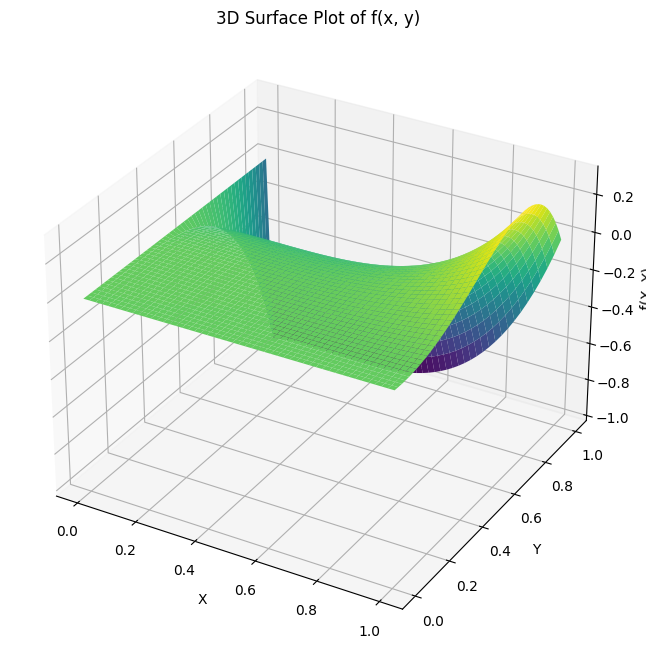

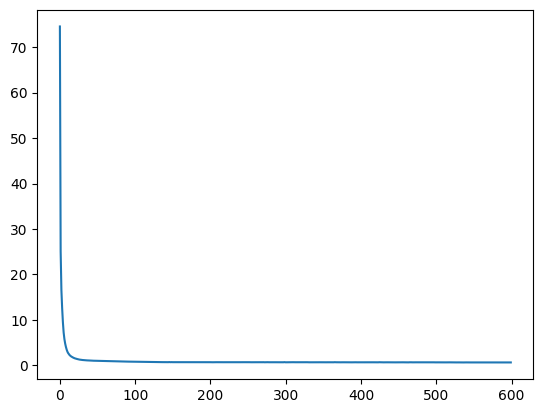

In [1108]:
model = Net()
data_length = 5000
f = lambda X: X[:,0]**4.76 * X[:,1]**2.123 - X[:,1]**5.43 #+ torch.exp(X[:,1])
dataloader_train = create_dataloader(f, input_dim =2, data_length=data_length)
dataloader_valid = create_dataloader(f, input_dim =2, data_length=data_length//10)
model, loss = train(model, dataloader_train, dataloader_valid, 600)
model.plot_model()
plt.plot(loss)
plt.show()

[('fc1.weight_mask', tensor([[0.+0.j, 1.+0.j, 0.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]])), ('fc2.weight_mask', tensor([[1.+0.j, 1.+0.j, 1.+0.j]]))]
[('fc1.weight_orig', Parameter containing:
tensor([[-1.2986e-03-3.2849e-03j, -2.8718e+00-8.2510e-05j,
         -5.7238e-03-2.5362e-06j,  1.6838e+00-9.4402e-05j],
        [-2.2414e+00+4.5935e-05j, -6.7748e-01+5.8619e-06j,
         -3.5566e-03+9.1832e-03j,  1.7290e+00+2.7010e-05j],
        [ 1.5887e-03-3.8990e-04j, -1.2836e+00+6.9680e-06j,
          1.5168e+00+8.2476e-06j,  1.3309e+00+2.0164e-05j]],
       requires_grad=True)), ('fc2.weight_orig', Parameter containing:
tensor([[-0.0773+2.8046e-06j,  0.1799+2.2155e-05j, -0.5489-5.6058e-05j]],
       requires_grad=True))]


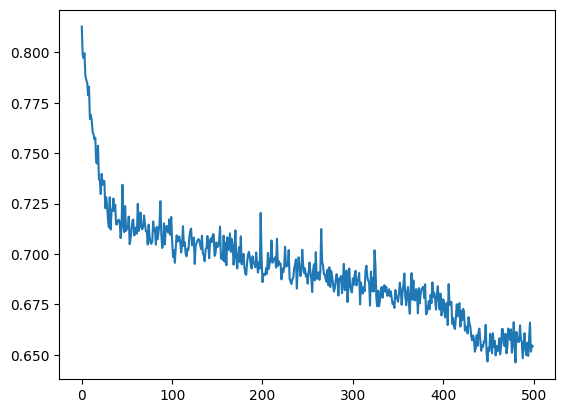

In [1109]:
plt.plot(loss[100:])
#print(loss)
print(list(model.named_buffers()))
print(list(model.named_parameters()))

In [986]:
for p in model.parameters():
    print(p)
model

Parameter containing:
tensor([[ 4.7671e+00-4.7703e-07j,  1.9901e+00-1.4128e-06j,
         -2.3760e-02-5.8331e-04j,  9.0511e-04-4.5560e-03j],
        [ 6.9736e-03+1.8822e-05j, -6.8865e-03-7.9421e-03j,
          7.8382e-03+8.2653e-04j, -3.9964e-01+2.4871e-05j],
        [-1.2558e-03-3.5132e-04j,  2.2437e+00-2.0269e-05j,
          1.8958e-03-8.1330e-04j, -2.3228e+00+3.6308e-05j]],
       requires_grad=True)
Parameter containing:
tensor([[0.9674+1.0028e-06j, 0.4262+2.1774e-05j, 0.0547+1.5702e-06j]],
       requires_grad=True)


Net(
  (fc1): Linear(in_features=4, out_features=3, bias=False)
  (fc2): Linear(in_features=3, out_features=1, bias=False)
)

In [688]:
print(model.fc2.weight)

Parameter containing:
tensor([[-1.0009e+00+1.0100e-06j,  9.4919e-04+4.4077e-05j,
          1.0011e+00-1.4992e-05j]], requires_grad=True)


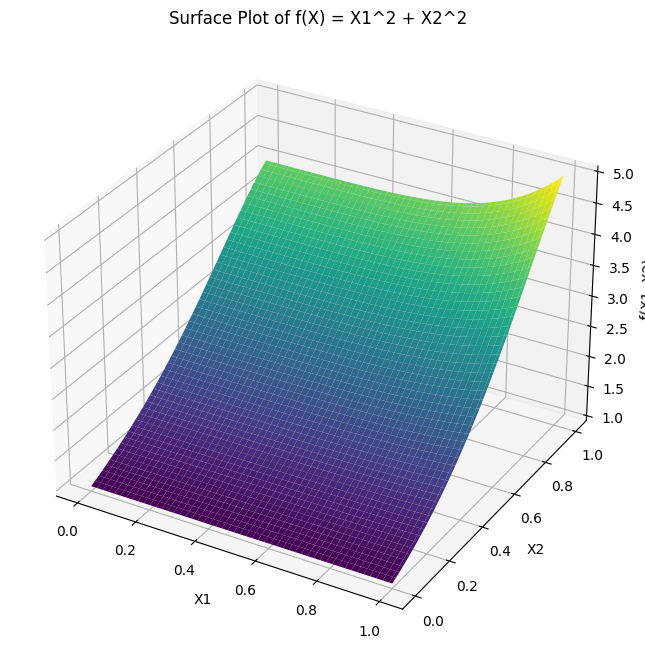

In [970]:
x = np.linspace(0, 1, 100)  # Change the range as needed
y = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x, y)  # Create a meshgrid for x and y

# Stack the grid points and evaluate the function
Z = f(np.column_stack((X1.ravel(), X2.ravel())))  # Evaluate f on the meshgrid
Z = Z.reshape(X1.shape)  # Reshape back to 2D for plotting

# Plot the surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none')

# Set labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('f(X1, X2)')
ax.set_title('Surface Plot of f(X) = X1^2 + X2^2')

# Show the plot
plt.show()